# FEDERATED LEARNING

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadr
import numpy as np

# Collect data

Dataset documentation : "https://cas.uqam.ca/pub/web/CASdatasets-manual.pdf"

Here, we concentrate on 3 different datasets on Motor Insurers : 
- `freMPL` (*French Motor Personal Line datasets*): This collection of ten datasets comes from a private motor French insurer. Each dataset includes risk features, claim amount and claim history of around 30,000 policies for year 2004. We decided to concacenate the differents freMPL datasets to focus on statistics.
- `beMTPL16` (*Belgian motor third-part liability dataset*): The dataset beMTPL was collected by an unknown Belgium insurer. It consists of 70 791 claims for private motor insurance.
- `euMTPL` (*European motor TPL insurance*): The euMTPL compiles three years of experience from a European MTPL (Motor Third Party Liability) portfolio, including frequency and severity values for different types of losses. The data was collected during the first decade of the 21st century.

In [3]:
#Change the paths to the location of the data on your machine
fre_path="/Users/nayelbenabdesadok/Documents/GitHub/Federated_Learning_Milliman/data_comparaison/freMPL.csv"
be_path="/Users/nayelbenabdesadok/Documents/GitHub/Federated_Learning_Milliman/data_comparaison/beMTPL97.rda"
eu_path="/Users/nayelbenabdesadok/Documents/GitHub/Federated_Learning_Milliman/data_comparaison/euMTPL.rda"

file_paths = [be_path, eu_path]

In [4]:
def load_rda(file_paths):
  dataframes = {}
  for file_path in file_paths:
      result = pyreadr.read_r(file_path)
      for key in result.keys():
          dataframes[key] = result[key]
  return dataframes

In [5]:
df_fre=pd.read_csv(fre_path)

In [6]:
df_0 = load_rda(file_paths)
dataframes = {
    "French": df_fre,
    "Belgium": df_0["beMTPL97"],
    "European": df_0["euMTPL"]
}

In [7]:
print("French columns:", dataframes["French"].columns)
print("Belgium columns:", dataframes["Belgium"].columns)
print("European columns:", dataframes["European"].columns)


French columns: Index(['Exposure', 'LicAge', 'RecordBeg', 'Gender', 'MariStat', 'SocioCateg',
       'VehUsage', 'DrivAge', 'HasKmLimit', 'BonusMalus', 'ClaimAmount',
       'ClaimInd'],
      dtype='object')
Belgium columns: Index(['id', 'expo', 'claim', 'nclaims', 'amount', 'average', 'coverage',
       'ageph', 'sex', 'bm', 'power', 'agec', 'fuel', 'use', 'fleet',
       'postcode', 'long', 'lat'],
      dtype='object')
European columns: Index(['policy_id', 'group', 'fuel_type', 'year', 'vehicle_category',
       'vehicle_use', 'province', 'horsepower', 'gender', 'age', 'exposure',
       'cost_nc', 'num_nc', 'cost_cg', 'num_cg', 'cost_fcg', 'num_fcg',
       'cost_cd', 'num_cd'],
      dtype='object')


In [8]:
dataframes["European"]["cost_claim"] = dataframes["European"]["cost_nc"] + dataframes["European"]["cost_cg"] + dataframes["European"]["cost_fcg"] + dataframes["European"]["cost_cd"] 


In [9]:
dataframes["European"]["cost_claim"].describe()

count    2.373197e+06
mean     3.058943e+02
std      4.005364e+03
min     -1.034309e+04
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.452709e+06
Name: cost_claim, dtype: float64

# Choice of the variables to compare & Data Cleaning

Since the datasets are not identical, we need to select a common variable that will serve as the basis for comparison.
The target target variables are : 
- `Exposure` (*French :*`Exposure`, *Belgium :*`expo`, *European :*`exposure`): a numeric time of exposure, in years. -- **integer**
- `DriverAge` (*French :*`DrivAge`, *Belgium :*`ageph`, *European :*`age`): age of the driver -- **integer**
- `Gender` (*French :*`Gender`, *Belgium :*`sex`, *European :*`gender`): gender of the driver -- **{Male: 0,Female: 1}**
- `VehiculeUsage` (*French :*`VehUsage`, *Belgium :*`use`, *European :*`vehicle_use`): age of the driver -- **integer**
- `ClaimAmout` (*French :*`ClaimAmount`, *Belgium :*``, *European :*`cost_...`(differnt variables)):Total claim amount of the guarantee -- **real number**. For the european dataset, We will sum all the different `cost`variables to agregate all the sinisters.

Since the datasets have different variables, it is challenging to compare them accurately. Moreover, the French database had to be concatenated, and some variables had to be removed, for example.

In [17]:
french_data = dataframes["French"].rename(columns={
    'Exposure': 'Exposure',
    'DrivAge': 'DriverAge',
    'Gender': 'Gender',
    'VehUsage': 'VehiculeUsage',
    'ClaimAmount': 'ClaimAmount'
})[['Exposure', 'DriverAge', 'Gender', 'VehiculeUsage', 'ClaimAmount']]

belgium_data = dataframes["Belgium"].rename(columns={
    'expo': 'Exposure',
    'ageph': 'DriverAge',
    'sex': 'Gender',
    'use': 'VehiculeUsage',
    'amount': 'ClaimAmount'
})[['Exposure', 'DriverAge', 'Gender', 'VehiculeUsage', 'ClaimAmount']]

european_data = dataframes["European"].rename(columns={
    'exposure': 'Exposure',
    'age': 'DriverAge',
    'gender': 'Gender',
    'vehicle_use': 'VehiculeUsage',
    'cost_claim': 'ClaimAmount'
})[['Exposure', 'DriverAge', 'Gender', 'VehiculeUsage', 'ClaimAmount']]

In [30]:
french_data["VehiculeUsage"]

0                   Professional
1         Private+trip to office
2                   Professional
3                   Professional
4                   Professional
                   ...          
243060              Professional
243061                   Private
243062                   Private
243063                   Private
243064    Private+trip to office
Name: VehiculeUsage, Length: 243065, dtype: object

In [16]:
belgium_data.describe()

,Exposure,DriverAge,ClaimAmount
count,163212.000000,163212.000000,163212.000000
mean,0.889744,47.000950,162.150883
std,0.244202,14.831561,1374.575776
min,0.002740,18.000000,0.000000
25%,1.000000,35.000000,0.000000
50%,1.000000,46.000000,0.000000
75%,1.000000,58.000000,0.000000
max,1.000000,95.000000,140032.424473


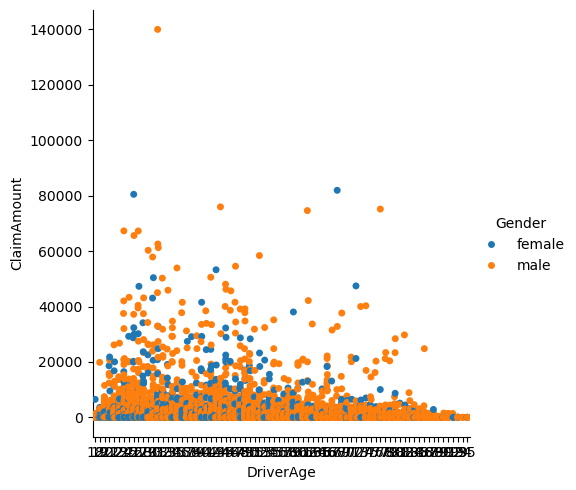

In [ ]:
sns.catplot(data=belgium_data, x="DriverAge", y="ClaimAmount",hue="Gender")

/Users/nayelbenabdesadok/opt/anaconda3/envs/fed_learning/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self._figure.tight_layout(*args, **kwargs)


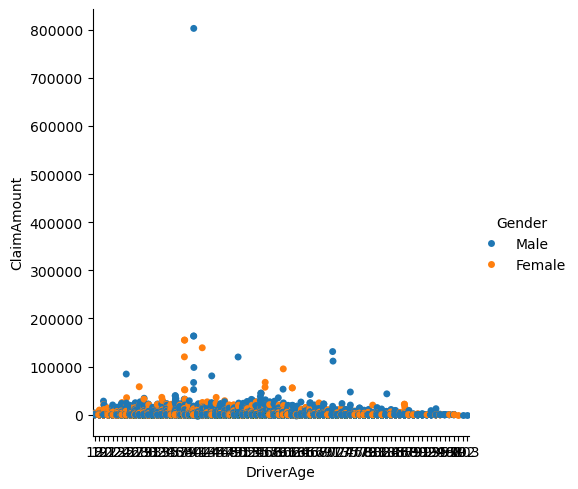

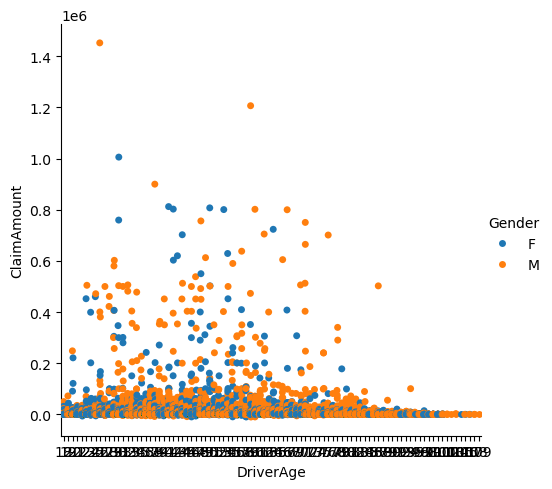

In [28]:
sns.catplot(data=french_data, x="DriverAge", y="ClaimAmount",hue="Gender")
sns.catplot(data=european_data, x="DriverAge", y="ClaimAmount",hue="Gender")


In [12]:
def missing_values(df):
  return(df.isnull().sum())

In [13]:
def outlier_values(df):
    outliers = pd.Series(dtype="float64")

    for col in df.select_dtypes(include=["number"]):  
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        mask = (df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))
        outliers[col] = mask.mean() * 100  
    return outliers